In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import sqrt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,confusion_matrix,plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [30]:
# !pip install imblearn

In [31]:
train=pd.read_csv(r'C:\Users\jayac\Downloads\Dataset\Insurancepred_train.csv')
test=pd.read_csv(r'C:\Users\jayac\Downloads\Dataset\Insurancepred_test.csv')


In [32]:
train.shape

(381109, 12)

In [33]:
test.shape

(127037, 11)

In [34]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [35]:
train['Source']='train'
test['Source']='test'

In [36]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Source
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,train
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,train
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,train
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,train
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,train


In [37]:
df=pd.concat([train,test],axis=0)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              381109 non-null  float64
 12  Source                508146 non-null  object 
dtypes: float64(4), int64(5), object(4)
memory usage: 54.3+ MB


In [39]:
df['Gender'].unique()
df['Driving_License'].unique()
(df['Region_Code'].unique())
df['Previously_Insured'].unique()
df['Vehicle_Age'].unique()
df['Vehicle_Damage'].unique()
df['Age'].unique()
df['Policy_Sales_Channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

In [40]:
df['Policy_Sales_Channel'].value_counts(sort=True)

152.0    179523
26.0     106594
124.0     98299
160.0     29090
156.0     14313
          ...  
143.0         1
149.0         1
144.0         1
142.0         1
84.0          1
Name: Policy_Sales_Channel, Length: 157, dtype: int64

In [41]:
df.loc[~df['Policy_Sales_Channel'].isin([152.0,26.0,124.0,160.0,156.0]),['Policy_Sales_Channel']]=999

In [42]:
def Preprocess(df3):
    lm=LabelEncoder()
    df3['Gender']=lm.fit_transform(df3['Gender'])
    vehicle_age=pd.get_dummies(df3['Vehicle_Age'],prefix='Vehicle_Age')
    df3=pd.concat([df3,vehicle_age],axis=1)
    df3['Vehicle_Damage']=lm.fit_transform(df3['Vehicle_Damage'])
    df3['Age']=pd.cut(df3['Age'],5)
    age_encoded=pd.get_dummies(df3['Age'],prefix='Age')
    df3=pd.concat([df3,age_encoded],axis=1)
    policy_encoded=pd.get_dummies(df['Policy_Sales_Channel'],prefix='Policy_channel')
    df3=pd.concat([df3,policy_encoded],axis=1)
    df3['Region_Code']=df3['Region_Code'].apply(lambda x: int(x))
    df3.drop(columns=['Age','Vehicle_Age','Policy_Sales_Channel'],inplace=True)
    return df3

    

In [43]:
df_final=Preprocess(df)

In [44]:
df_final.shape

(508146, 24)

In [45]:
train_preprocessed=df_final[df_final['Source']=='train']
test_preprocessed=df_final[df_final['Source']=='test']


In [46]:
train_preprocessed.shape

(381109, 24)

In [47]:
train_x=train_preprocessed.drop(columns=['id','Response','Source'])
train_y=train_preprocessed['Response']
test_x=test_preprocessed.drop(columns=['id','Response','Source'])

In [48]:
train_x.shape,train_y.shape

((381109, 21), (381109,))

In [49]:
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
train_x, train_y = pipeline.fit_resample(train_x, train_y)

In [50]:
train_x.shape,train_y.shape

((300957, 21), (300957,))

In [51]:
train_y.value_counts()

0.0    200638
1.0    100319
Name: Response, dtype: int64

In [52]:
sm=StandardScaler()
train_scaled=sm.fit_transform(train_x)
test_scaled=sm.fit_transform(test_x)

## Logistic Regression

In [53]:
def logistic_model():
    lm=LogisticRegression()
    lm.fit(train_scaled,train_y)
    pred_train=lm.predict(train_scaled)
    print(f'Accuracy Score {metrics.accuracy_score(train_y,pred_train)}')
    print(f'f1_score {metrics.f1_score(train_y,pred_train)}')
    print(f'ROC_AUC_Score {metrics.roc_auc_score(train_y,pred_train)}')
    print(f'Confusion Matrix {metrics.confusion_matrix(train_y,pred_train)}')
    print(f'Classification report \n {metrics.classification_report(train_y,pred_train)}')
    plot_roc_curve(lm,train_scaled,train_y)

C:\Users\jayac\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score 0.8284572214635313
f1_score 0.6853144295649736
ROC_AUC_Score 0.7614360190990739
Confusion Matrix [[193114   7524]
 [ 44103  56216]]
Classification report 
               precision    recall  f1-score   support

         0.0       0.81      0.96      0.88    200638
         1.0       0.88      0.56      0.69    100319

    accuracy                           0.83    300957
   macro avg       0.85      0.76      0.78    300957
weighted avg       0.84      0.83      0.82    300957



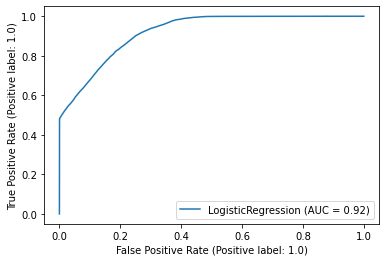

In [54]:
logistic_model()

## Random Forest Regressor

In [55]:
NoofEstimator = [5, 10, 15, 20]
MinSampleLeaf = [1, 3, 5, 7,10]
MaxFeature = np.arange(0.1, 1.1, 0.1)
bootstraps=[True,False]
min_samples_splits=[2,4,6,8,10]
n_jobs1=[-1]


In [56]:
rf=RandomForestClassifier()

In [75]:
rf_grid=GridSearchCV(estimator=rf, param_grid=  
                     dict(n_estimators = NoofEstimator,
                                         min_samples_leaf = MinSampleLeaf,
                                         max_features = MaxFeature,
                         bootstrap=bootstraps,
                         min_samples_split=min_samples_splits,n_jobs=n_jobs1,))
rf_grid.fit(train_x,train_y) 
print(rf_grid.best_estimator_)
pred_train=rf_grid.predict(train_x)
pred_test=rf_grid.predict(test_x)
print(f'Accuracy Score {metrics.accuracy_score(train_y,pred_train)}')
print(f'f1_score {metrics.f1_score(train_y,pred_train)}')
print(f'ROC_AUC_Score {metrics.roc_auc_score(train_y,pred_train)}')
print(f'Confusion Matrix {metrics.confusion_matrix(train_y,pred_train)}')
print(f'Classification report \n {metrics.classification_report(train_y,pred_train)}')
plot_roc_curve(rf_grid,train_scaled,train_y)


KeyboardInterrupt: 

Accuracy Score 0.9576650484953
f1_score 0.9344966042702394
ROC_AUC_Score 0.9447362912309731
Confusion Matrix [[197332   3306]
 [  9435  90884]]
Classification report 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97    200638
         1.0       0.96      0.91      0.93    100319

    accuracy                           0.96    300957
   macro avg       0.96      0.94      0.95    300957
weighted avg       0.96      0.96      0.96    300957



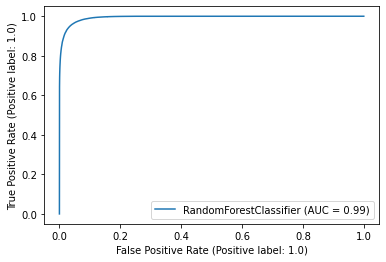

In [76]:
rf=RandomForestClassifier(max_features=0.5, min_samples_split=8, n_estimators=20,
                       n_jobs=-1)
rf.fit(train_scaled,train_y) 
pred_train=rf.predict(train_scaled)
pred_test=rf.predict(test_scaled)
print(f'Accuracy Score {metrics.accuracy_score(train_y,pred_train)}')
print(f'f1_score {metrics.f1_score(train_y,pred_train)}')
print(f'ROC_AUC_Score {metrics.roc_auc_score(train_y,pred_train)}')
print(f'Confusion Matrix {metrics.confusion_matrix(train_y,pred_train)}')
print(f'Classification report \n {metrics.classification_report(train_y,pred_train)}')
plot_roc_curve(rf,train_scaled,train_y)


In [65]:
submission=pd.read_csv(r'C:\Users\jayac\Downloads\Dataset\Insurancesubmission.csv')
submission.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


In [66]:
submission['Response']=pred_test

In [68]:
submission['Response']=submission['Response'].apply(lambda x:int(x))

In [69]:
submission.to_csv(r'C:\Users\jayac\Downloads\Dataset\Out_Insurance_seller.csv')

Accuracy Score 0.8385815913901321
f1_score 0.7343758543386735
ROC_AUC_Score 0.7962898354249943
Confusion Matrix [[185222  15416]
 [ 33164  67155]]
Classification report 
               precision    recall  f1-score   support

         0.0       0.85      0.92      0.88    200638
         1.0       0.81      0.67      0.73    100319

    accuracy                           0.84    300957
   macro avg       0.83      0.80      0.81    300957
weighted avg       0.84      0.84      0.83    300957



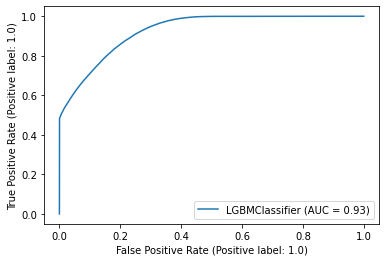

In [81]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)
clf.fit(train_scaled,train_y) 
pred_train=clf.predict(train_scaled)
pred_test=clf.predict(test_scaled)
print(f'Accuracy Score {metrics.accuracy_score(train_y,pred_train)}')
print(f'f1_score {metrics.f1_score(train_y,pred_train)}')
print(f'ROC_AUC_Score {metrics.roc_auc_score(train_y,pred_train)}')
print(f'Confusion Matrix {metrics.confusion_matrix(train_y,pred_train)}')
print(f'Classification report \n {metrics.classification_report(train_y,pred_train)}')
plot_roc_curve(clf,train_scaled,train_y)

## KNN

In [ ]:
def KNN_predicts(train_x, test_x, train_y, neighbours, 
                 metric = 'manhattan', 
                 weights = 'uniform'):

    KNN = KNeighborsClassifier(n_neighbors= neighbours, metric = metric, 
                               weights = weights, n_jobs = -1)
    KNN.fit(train_scaled, train_y)
    pred_train = KNN.predict(train_scaled)
    print('Accuracy: ', accuracy_score(train_y, pred_train)) 
    print('-'*100)
    return KNN

In [ ]:
for k in range(3, 11):
    print('Accuracy score on KNN using n_neighbors = {0}:'.format(k), end = ' ')
    KNN_predicts(train_x, test_x, train_y, k)

In [ ]:
k=7
for metric in ['euclidean','minkowski','manhattan','chebyshev']:
    print('Accuracy score on KNN using {} metric and {} neighbors:'.format(metric,k), end = ' ')
    KNN_predicts(train_x, test_x, train_y, StandardScaler(), k,metric)

In [ ]:
for weight in ['uniform','distance']:
    print('Accuracy score on KNN using  neighbors {} weights: '.format(weight), end = ' ')
    KNN_predicts(train_x, test_x, train_y, StandardScaler(), 7,'minkowski',weights=weight)

In [ ]:
def KNN():
    KNN = KNeighborsClassifier(n_neighbors= neighbours, metric = metric, 
                               weights = weights, n_jobs = -1)
    KNN.fit(train_scaled, train_y)
    pred_train = KNN.predict(train_scaled)
    print(f'Accuracy Score {metrics.accuracy_score(train_y,pred_train)}')
    print(f'f1_score {metrics.f1_score(train_y,pred_train)}')
    print(f'ROC_AUC_Score {metrics.roc_auc_score(train_y,pred_train)}')
    print(f'Confusion Matrix {metrics.confusion_matrix(train_y,pred_train)}')
    print(f'Classification report \n {metrics.classification_report(train_y,pred_train)}')
    plot_roc_curve(lm,train_scaled,train_y)
    